## Supernovae II

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

(35.0, 50.0)

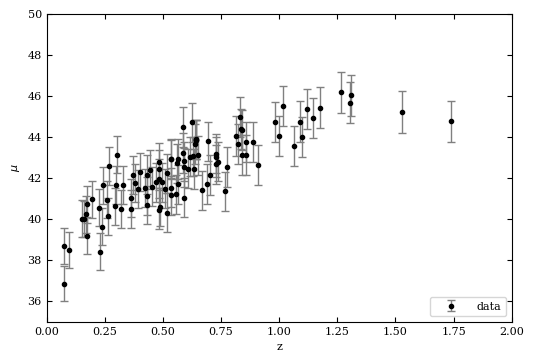

In [4]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)


plt.figure(figsize=(6,4))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

We will use gpr as our regression let us try a few different bandwiths

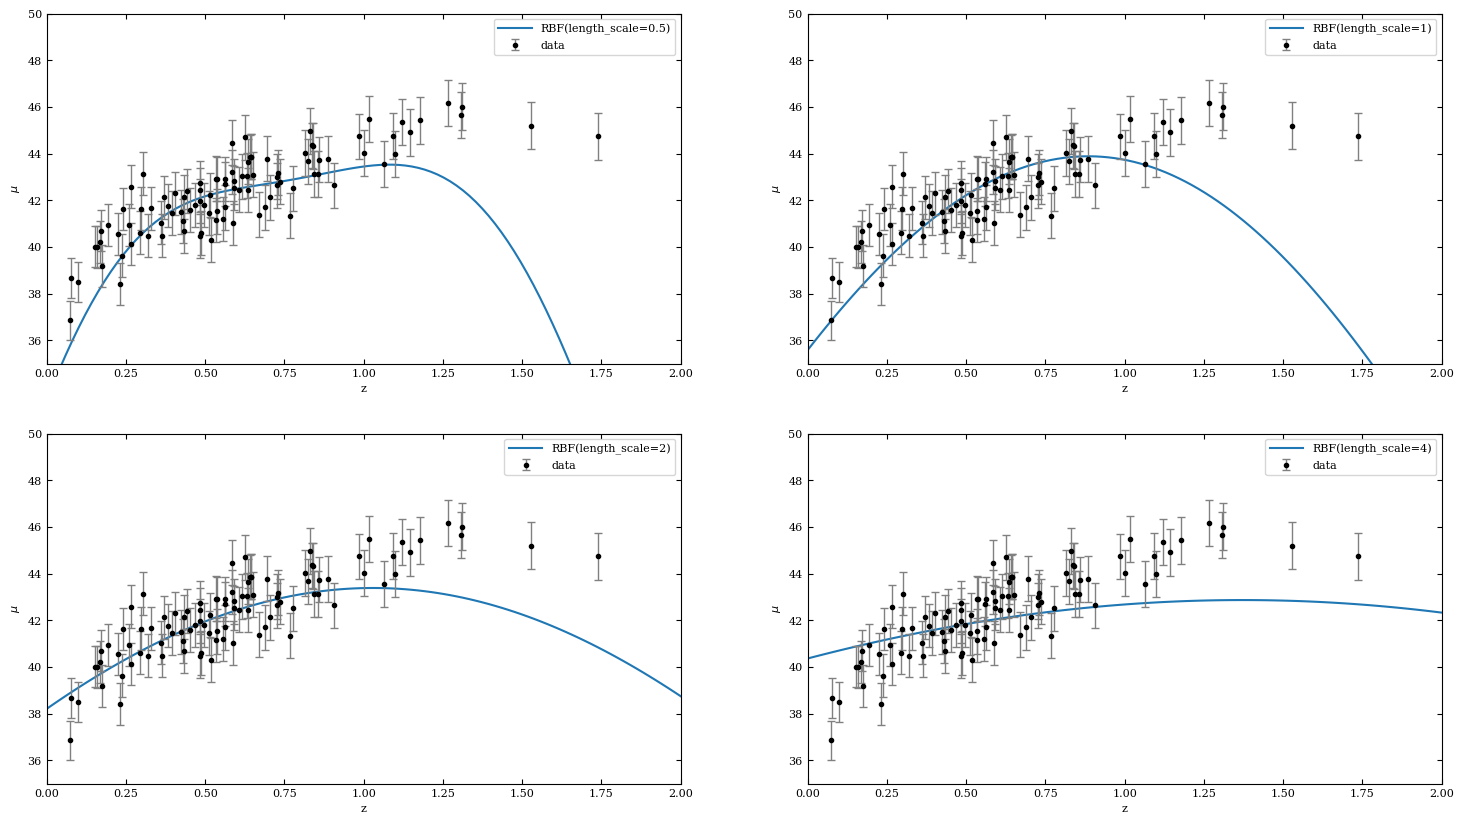

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

x = z_sample
X = x[:, None]
y = mu_sample

xgrid = np.linspace(0,2,100)
xgrid = xgrid[:, None]

radial = [kernels.RBF(length_scale=0.5), kernels.RBF(length_scale=1.0), kernels.RBF(length_scale=2.0), kernels.RBF(length_scale=4.0)]

fig,axs = plt.subplots(2,2, figsize=(18,10))
c_axs = np.concatenate(axs)

for k,ax in zip(radial,c_axs):   
    gp = GaussianProcessRegressor(kernel=k, optimizer=None, alpha=dmu** 2)
    gp.fit(X,y)
    y_pred, dy_pred = gp.predict(xgrid, return_std=True)
    ax.plot(xgrid, y_pred, label=str(k))
    
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.set_xlabel("z")
    ax.set_ylabel("$\mu$")
    ax.legend()
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)

Not too promising, maybe we need to add a constant amplitude?

In [8]:
xgrid = np.linspace(0,2,100)
xgrid = xgrid[:, None]

A=70
w = 2

k = kernels.RBF(2, (1e-2, 1e2)) * kernels.ConstantKernel(A) #best fit,adding a constant

gp = GaussianProcessRegressor(kernel=k, optimizer=None,
                              alpha=(dmu)**2, )
gp.fit(X,y)
y_pred, dy_pred = gp.predict(xgrid, return_std=True)

Best fit with GPR 
Amplitude: 70  length scale: 2


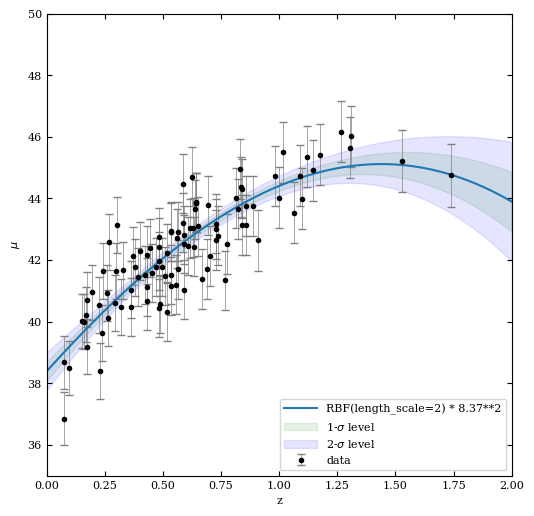

In [9]:
plt.figure(figsize=(6,6))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=.5,label='data')

x_fit = np.linspace(0,2,100)
plt.plot(x_fit, y_pred, label=str(k))
plt.fill_between(x_fit, y_pred - dy_pred, y_pred + dy_pred, 
                color='g', alpha=0.1, label='1-$\sigma$ level')
plt.fill_between(x_fit, y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, 
                color='b', alpha=0.1, label='2-$\sigma$ level')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

print(f'Best fit with GPR \nAmplitude: {A}  length scale: {w}')

Much better, the estimated error is directly given by the gpr metod

## Checking with the math

These are supernovae, we want to see if their distribution is predicted by our cosomological model

In [10]:
from astropy.cosmology import LambdaCDM

def LCDM(z, H0, Om=1):
    if Om > 0:
        cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
        return cosmo_tmp.distmod(z).value #modulus of the distance
    return 0

In [11]:
z = np.random.uniform(0,2,10)
H0 = 70
Om = .2
#testing out the model for 10 different redshifts ranging from o to 2
d = LCDM(z, H0, Om)


for z_i, d_i in zip(z,d):
    print(f'z: {z_i:<20} d: {d_i}')

z: 0.04685864596160383  d: 36.59642725253519
z: 0.4345730180984728   d: 41.9674527656008
z: 1.219195414566444    d: 44.79532039664135
z: 1.5603182295835483   d: 45.483374183958446
z: 0.19770127426706607  d: 39.96069471514293
z: 1.359274788458908    d: 45.098987589099636
z: 1.5890290689944104   d: 45.534084694559795
z: 1.8329240699982443   d: 45.93010499727515
z: 0.8546271750107601   d: 43.805062496128485
z: 1.9550723949876856   d: 46.108276769250274


In [12]:
from scipy.optimize import curve_fit

n_params,n_cov = curve_fit(LCDM, x, y)

Let's now fit the model to the deta using the `curve_fit` routine provided by sklearn

In [13]:
params, std = np.round(n_params, 5), np.round(np.sqrt(n_cov), 5)

print(f'H0: {params[0]} +/- {std[0,0]}')
print(f'Om0: {params[1]} +/- {std[1,1]}')

H0: 70.37108 +/- 7.48201
Om0: 0.27732 +/- 0.24444


/tmp/ipykernel_6359/322451203.py:1: RuntimeWarning: invalid value encountered in sqrt
  params, std = np.round(n_params, 5), np.round(np.sqrt(n_cov), 5)


In [14]:
print(n_cov) #curve fit does a good job in costraining Om but not in constraining H0

[[55.98049456 -1.67769886]
 [-1.67769886  0.05975107]]


Best fit with curve_fit

H0: 70.37108 +/- 55.98049456160964
Om0: 0.27732 +/- 0.05975107000541792


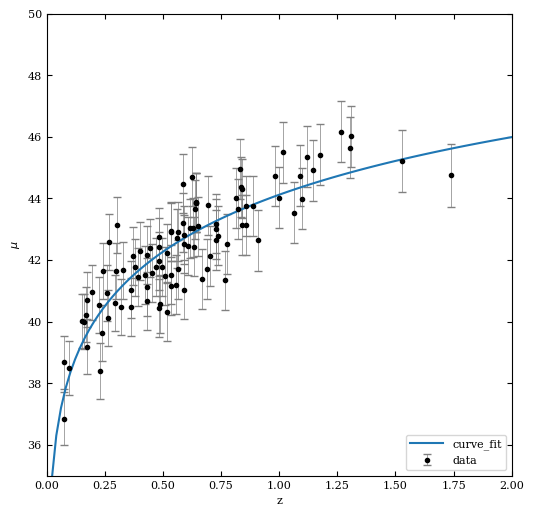

In [15]:
plt.figure(figsize=(6,6))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=.5,label='data')

x_fit = np.linspace(.001,2,100)
d_fit = LCDM(x_fit, params[0], params[1]),
d_fit = np.array(d_fit)

plt.plot(x_fit, d_fit[0], label='curve_fit')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

print(f'Best fit with curve_fit\n')
print(f'H0: {params[0]} +/- {n_cov[0,0]}')
print(f'Om0: {params[1]} +/- {n_cov[1,1]}')

## Parameter estimation 

Let's try a Bayesian approach and use MCMC instead of `curve_fit`

### MCMC

We will use the most general priors

In [16]:
import emcee
from scipy import stats

In [17]:
def prior(p):
    priors = np.zeros(2)
    #in this case all parameters are independent so the prior is the product of all priors
    #the p(loga) = uniform means p(a) = 1/uniform
    priors[0] = stats.uniform.pdf(p[0], loc=0, scale=100) #this will generate the pdf in the domain [0,100]
    priors[1] = stats.uniform.pdf(p[1], loc=0, scale=1) #Om in (0,1)
    
    return np.prod(priors)

In [18]:
#p is my parameter array
def loglikelihood(p, data, model=LCDM):
    #defining my parameters theta = p
    H0, Om = p
    x, y, sigma_y = data
    
    y_fit = model(x, H0, Om)
    #always makes sense to choose gaussian likelihood
    #because without any prior notion the data will be distributed 
    #gaussianly around the model
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y)) #y_fit is the center

In [19]:
# emcee wants ln of posterior pdf
def logpost(p):
    global data
    
    lp = np.log(prior(p))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return loglikelihood(p, data) + lp

In [20]:
ndim = 2       # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

data = np.vstack([z_sample, mu_sample, dmu])
#print(data[1])

In [21]:
# initialize parameters
np.random.seed(1)
starting_guesses = np.zeros([nwalkers, ndim])

for i in range(nwalkers):
    # you want to initialize the guesses at a reasonable value, recall the fit by curve_fit
    starting_guesses[i,0] = 70 + 1e-2*np.random.uniform(0,50)
    starting_guesses[i,1] = .3 + 1e-2*np.random.uniform(0,50)

print(starting_guesses)

[[70.208511    0.66016225]
 [70.00005719  0.45116629]
 [70.07337795  0.3461693 ]
 [70.09313011  0.47278036]
 [70.19838374  0.56940837]
 [70.20959726  0.64260975]
 [70.10222612  0.73905872]
 [70.0136938   0.63523376]
 [70.2086524   0.57934491]
 [70.07019347  0.39905074]]


In [22]:
from multiprocessing import cpu_count
from multiprocessing import Pool
import time
import emcee


ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

16 CPUs


In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)
start = time.time()
sampler.run_mcmc(starting_guesses, nsteps)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

/tmp/ipykernel_6359/4109657796.py:5: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))


Serial took 224.7 seconds


In [40]:
# the function call where all the work happens:
# with parallelization!!

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)
    start = time.time()
    sampler.run_mcmc(starting_guesses, nsteps)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

/tmp/ipykernel_288274/4109657796.py:5: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))


Multiprocessing took 233.0 seconds
1.0 times faster than serial


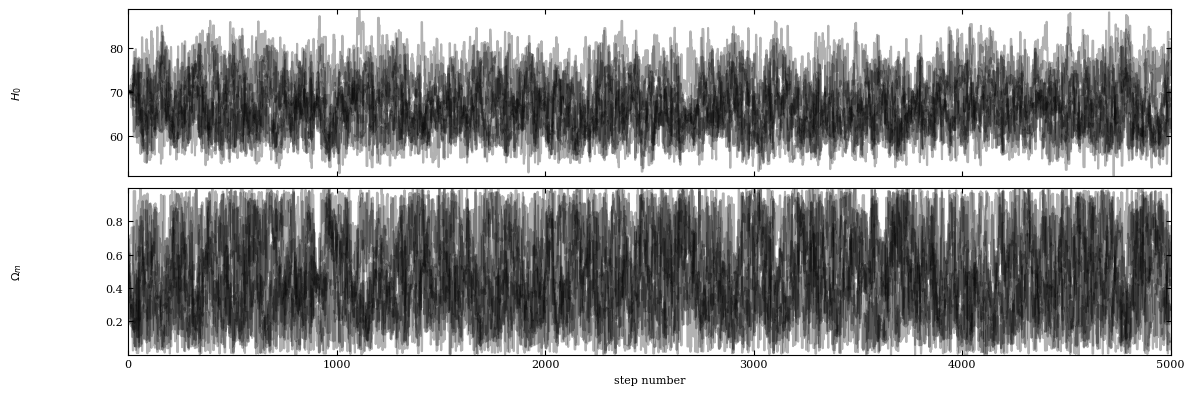

In [43]:
fig, axes = plt.subplots(2, figsize=(12, 4), sharex=True, tight_layout = True)
samples = sampler.get_chain()
labels = [r'$H_0$', r'$\Omega_m$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [44]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(50000, 2)


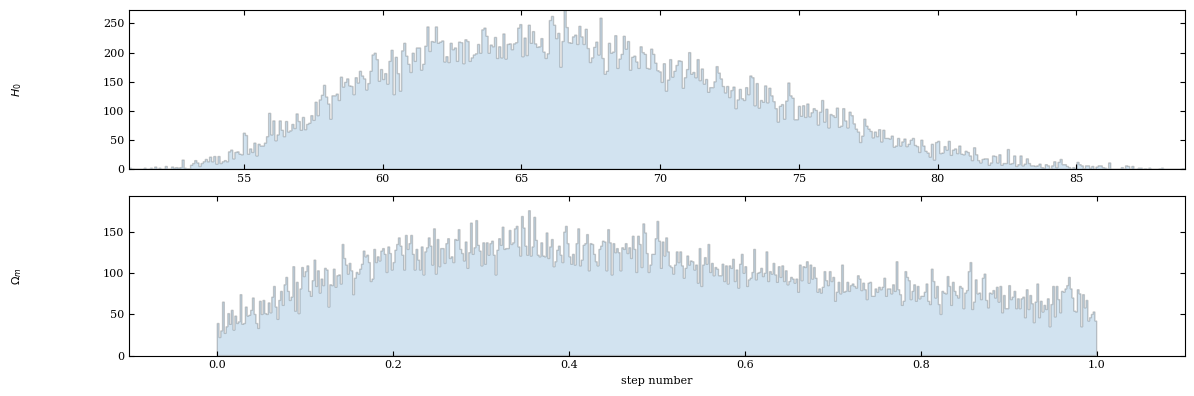

In [45]:
fig, axes = plt.subplots(2, figsize=(12, 4), tight_layout = True)
labels = [r'$H_0$', r'$\Omega_m$']
burn = 1000
w = 0 #walker

for i in range(2):
    ax = axes[i]
    ax.hist(flat_samples[burn:, i], bins = 500, 
            histtype='stepfilled', edgecolor = None, alpha=0.2)
    
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.margins(.1);

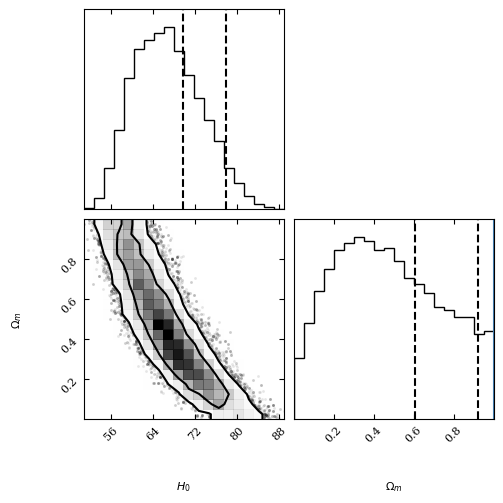

In [46]:
import corner

fb_samples = flat_samples[burn:, :]

fig = corner.corner(
    fb_samples, labels=labels, levels=[0.68, 0.95], truths=[1,1], quantiles=[.68,.95]
);

(100, 2)


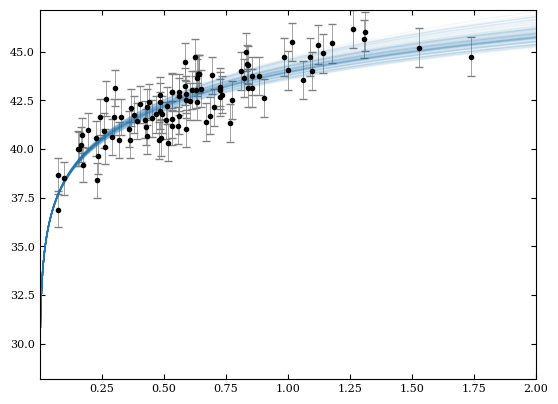

In [47]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=.5,label='data')
zz = np.linspace(0.001,2,1000)

p = fb_samples[::round(len(fb_samples)/100), :]
print(p.shape)

for i in range(100):
    plt.plot(zz, LCDM(zz, H0=p[1,0], Om=p[i,1]), 'C0', alpha = .05, lw = 1);

In [48]:
import pandas as pd

#the 90% credible region is the interval bw the 5th and 95th percentile, so my error will be 95-5
labels = [r'$H_0$', r'$\Omega_m$']
header = ['med', r'$\sigma_-$', r'$\sigma_+$', r'$\sigma_{90}$']
stats_ = []

for i,l in enumerate(labels):
    low,med,up = np.percentile(flat_samples[:,i],[5,50,95])
    stats_.append([round(med,3), round(up-med,3), round((low-med)/2,3), round((up-med)/2,3)])
    
stats_ = np.array(stats_)

df = pd.DataFrame(stats_, columns=header, index=labels)
df.style.set_table_attributes('style="font-size: 17px"')

display(df)

,med,$\sigma_-$,$\sigma_+$,$\sigma_{90}$
$H_0$,66.446,11.353,-4.511,5.676
$\Omega_m$,0.452,0.470,-0.182,0.235


In [49]:
print(stats_)

[[66.446 11.353 -4.511  5.676]
 [ 0.452  0.47  -0.182  0.235]]


In [50]:
p_sample = flat_samples[burn:, :]
print(p_sample.shape)

(49000, 2)


In [51]:
## ERRORS
mu_sample_fit = []
for i in range(p.shape[0]):
    mu_i=LCDM(zz, H0=p[i, 0], Om=p[i, 1])
    mu_sample_fit.append(mu_i)
    
mu_err = np.std(mu_sample_fit)
print(mu_err)

2.4868131431523084


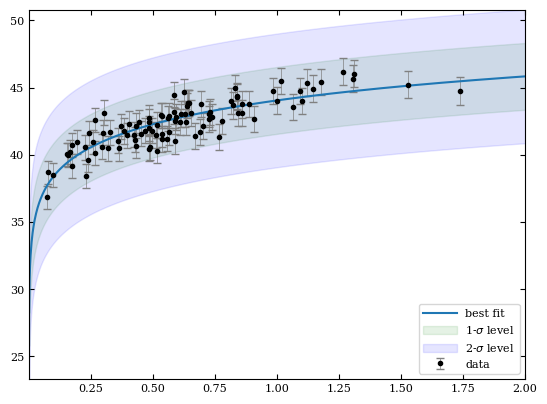

In [52]:
zz = np.linspace(0.001,2,1000)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=.5,label='data')

mu_fit=LCDM(zz, H0=stats_[0,0], Om=stats_[1,0])

plt.plot(zz, mu_fit, 'C0', label='best fit')
plt.fill_between(zz, mu_fit - mu_err, mu_fit + mu_err, 
                color='g', alpha=0.1, label='1-$\sigma$ level')
plt.fill_between(zz, mu_fit - 2 * mu_err, mu_fit + 2 * mu_err, 
color='b', alpha=0.1, label='2-$\sigma$ level')

plt.legend(loc='lower right');

## Do these data prove the presence of dark matter?

- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

In [53]:
def Matter(z, H0):
    Om = 1
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value #modulus of the distance

In [54]:
from scipy.optimize import curve_fit

model = Matter

n_params,n_cov = curve_fit(Matter, x, y)

In [55]:
params, cov = np.round(n_params, 5), np.round(n_cov, 5)

print(f'H0: {params[0]} +/- {cov[0,0]}')

H0: 57.42097 +/- 5.96948


Best fit with curve_fit

H0: 57.42097 +/- 5.96948


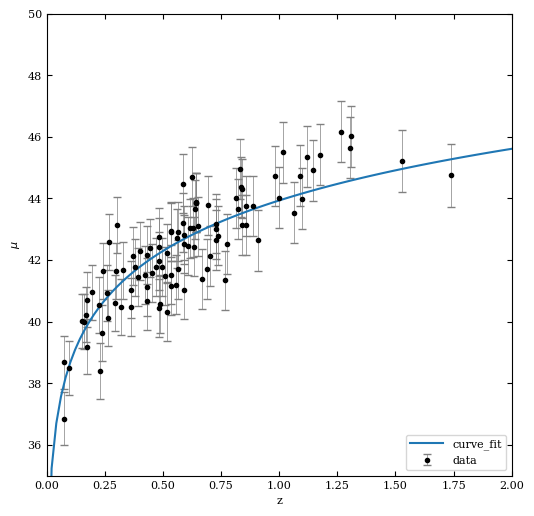

In [56]:
plt.figure(figsize=(6,6))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=.5,label='data')

x_fit = np.linspace(.001,2,100)
d_fit = model(x_fit, params[0]),
d_fit = np.array(d_fit)

plt.plot(x_fit, d_fit[0], label='curve_fit')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

print(f'Best fit with curve_fit\n')
print(f'H0: {params[0]} +/- {cov[0,0]}')

# Nested sampling

In [57]:
import dynesty
from scipy import stats

In [58]:
def nstdprior(u):
    x = np.array(u) #copy u to do operations
    x[0] *= 100.     # H_0
    x[1] *= 1.     # O_m
    
    return x   #priors of parameters array


In [59]:
ndim = 2 #dimension of the parameter space

nst_sampler = dynesty.NestedSampler(logpost, nstdprior, ndim)
nst_sampler.run_nested()
res1 = nst_sampler.results

1916it [01:42, 18.70it/s, +500 | bound: 1 | nc: 1 | ncall: 19129 | eff(%): 12.969 | loglstar:   -inf < -137.419 <    inf | logz: -140.399 +/-  0.057 | dlogz:  0.001 >  0.509]


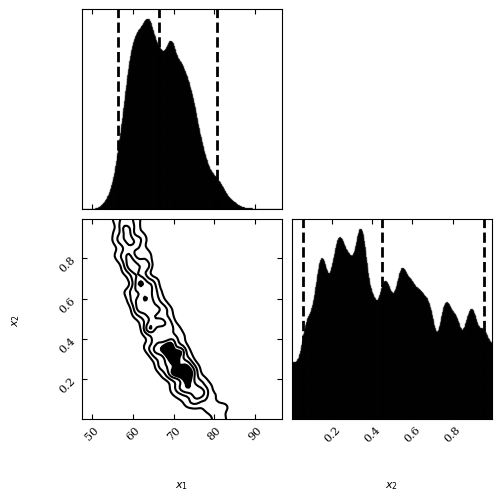

In [60]:
from dynesty import plotting as dyplot

cfig, caxes = dyplot.cornerplot(res1)

In [61]:
best_nst = res1.samples[-1:]
print(best_nst)

[[68.59808026  0.34288474]]


In [62]:
flat_samples2 = res1["samples"]

#the 90% credible region is the interval bw the 5th and 95th percentile, so my error will be 95-5
labels = ['H0', 'Om']
header = ['med', r'$\sigma_-$', r'$\sigma_+$', r'$\sigma_{90}$']
prop2 = [] 

for i,l in enumerate(labels):
    low,med,up = np.percentile(flat_samples2[:,i],[5,50,95])
    prop2.append([round(med,3), round(up-med,3), round((low-med)/2,3), round((up-med)/2,3)])
    
prop2 = np.array(prop2)

df = pd.DataFrame(prop2, columns=header, index=labels)
df.style.set_table_attributes('style="font-size: 17px"')

display(df)

,med,$\sigma_-$,$\sigma_+$,$\sigma_{90}$
H0,65.729,23.787,-22.063,11.893
Om,0.473,0.461,-0.202,0.230


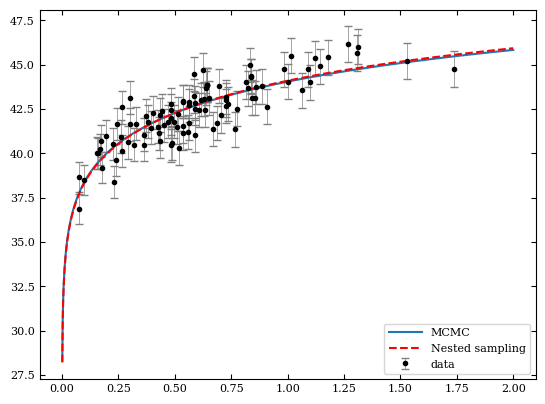

In [63]:
zz = np.linspace(0.001,2,1000)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=.5,label='data')

mu_fit=LCDM(zz, H0=stats_[0,0], Om=stats_[1,0])
mu_fit_nst=LCDM(zz, H0=best_nst[0,0], Om=best_nst[0,1])

plt.plot(zz, mu_fit, 'C0', label='MCMC')
plt.plot(zz, mu_fit_nst, 'r', ls='--', label='Nested sampling')
plt.margins(.05)

plt.legend(loc='lower right');